# Fixed Income Risk Monitoring
Code by Lili, Hui Gao \
Lastest Update: Lili, July 31st 2025\
Lastest Update: Lili, Aug 8th 2025

## Project Overview

This project analyzes the **SIAS Portfolio** and its benchmark to assess active positioning, risk exposures, and performance under various yield-curve scenarios.

**Key Steps and Outputs:**

1. **Portfolio & Benchmark Overview**

   * Loaded the most recent portfolio and benchmark data.
   * Created summary tables showing assets, maturities, market values, and base weights.
   * Calculated **duration** for each holding and determined **active weights** relative to the benchmark.

2. **Allocation Analysis**

   * Segmented holdings into **Government Bonds**, **Policy Bonds**, and **Corporate Bonds** for both portfolios.
   * Compared active weight differences in government and corporate bond allocations.

3. **Stress Testing Dashboard**

   * **Parallel Shift Stress Test**: Used the latest yield curve; adjustable basis point shocks to measure P\&L for portfolio, benchmark, and their difference.
   * **Curve Steepener/Flattener Test**: Adjustable short-end/long-end split to evaluate P\&L impact.
   * **Key Rate Shocks**: Applied shocks at specific maturities (2Y, 5Y, 10Y, 30Y) to assess P\&L sensitivity at different points on the curve.

This workflow provides a comprehensive view of **active duration positioning**, **sector allocation differences**, and **scenario-driven performance** to support risk assessment and portfolio decision-making.


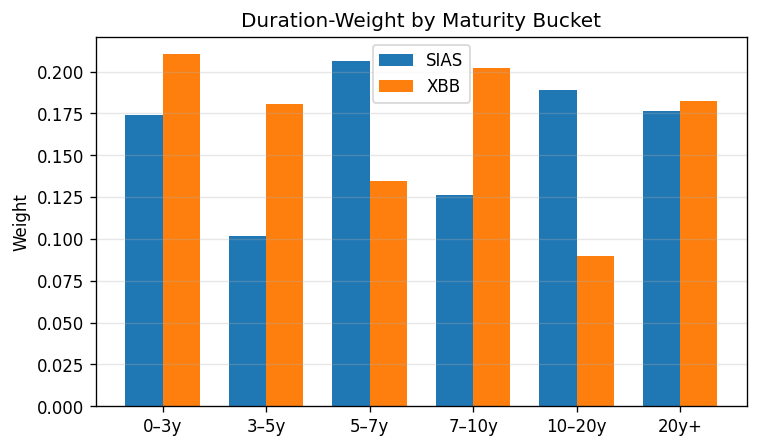

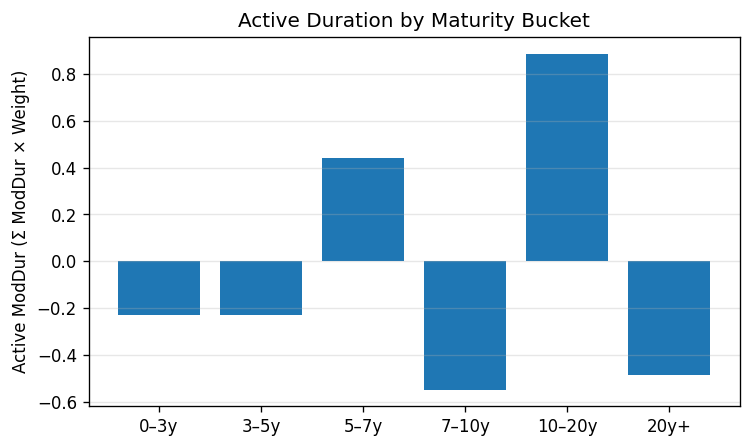

In [ ]:
# ====== RUN =================================================================
# 1) Load portfolio
port_df, port_asof, port_mv_tot = load_portfolio_xlsx(PORT_FILE, PORT_SHEET, ASSET_TAG)

# 2) Load benchmark (XBB)
bm_view, bm_asof, bm_mv_tot, bm_w_sum, bm_moddur = load_benchmark_xbb(BM_FILE)
# (bm_asof is already a Timestamp or NaT; bm_view columns: Asset, Coupon, Maturity, MarketValue, Weight, ModDur)

# 3) Portfolio aggregates
port_moddur = float(np.nansum(port_df["ModDur"] * port_df["Weight"]))
port_convex = float(np.nansum(port_df["Convexity"] * port_df["Weight"]))

# 4) Benchmark aggregates
bm_convex = np.nan
active_moddur = port_moddur - bm_moddur if pd.notna(bm_moddur) else np.nan
active_convex = port_convex - bm_convex if pd.notna(bm_convex) else np.nan

# ===== HEADER ================================================================
header_html = f"""
<div style="padding:8px 10px;border:1px solid #ddd;border-radius:8px;margin-bottom:8px">
  <div><b>Files</b>:
    <span>Portfolio: <code>{PORT_FILE.name}</code></span> &nbsp;|&nbsp;
    <span>Benchmark: <code>{BM_FILE.name}</code></span>
  </div>
  <div><b>As-of dates</b>:
    <span>Portfolio: <i>{port_asof.date()}</i></span> &nbsp;|&nbsp;
    <span>Benchmark: <i>{bm_asof.date() if pd.notna(bm_asof) else 'N/A'}</i></span>
  </div>
  <div style="margin-top:6px">
    <b>Totals</b>:
    <span>SIAS MV = <b>{port_mv_tot:,.0f}</b></span> &nbsp;|&nbsp;
    <span>{BM_NAME} MV = <b>{bm_mv_tot:,.0f}</b></span>
  </div>
  <div>
    <b>Durations</b>:
    <span>SIAS ModDur = <b>{port_moddur:.2f}</b> yrs</span> &nbsp;|&nbsp;
    <span>{BM_NAME} ModDur = <b>{bm_moddur if pd.notna(bm_moddur) else float('nan'):.2f}</b> yrs</span> &nbsp;|&nbsp;
    <span>Active ModDur = <b>{active_moddur if pd.notna(active_moddur) else float('nan'):.2f}</b> yrs</span>
  </div>
  <div>
    <b>Convexity</b>:
    <span>SIAS = <b>{port_convex:.4f}</b></span> &nbsp;|&nbsp;
    <span>{BM_NAME} = <b>{bm_convex if pd.notna(bm_convex) else float('nan'):.4f}</b></span> &nbsp;|&nbsp;
    <span>Active = <b>{active_convex if pd.notna(active_convex) else float('nan'):.4f}</b></span>
  </div>
</div>
"""
display(HTML(header_html))

# ===== TABLE 1: Portfolio (asset, coupon, maturity, MV, weight) =============
port_view = port_df.copy()
port_view["Asset"]    = port_view["Name"]
port_view["Maturity"] = port_view["Maturity"].dt.date
make_interactive_table(
    port_view.rename(columns={"MV":"Market Value"}),
    ["Asset","Coupon","Maturity","Market Value","Weight"],
    "<b>Portfolio — Holdings</b>"
)

# ===== TABLE 2: Benchmark (asset, coupon, maturity, MV, weight) =============
bm_tbl = bm_view.copy()
bm_tbl["Maturity"] = bm_tbl["Maturity"].dt.date
make_interactive_table(
    bm_tbl.rename(columns={"MarketValue":"Market Value"}),
    ["Asset","Coupon","Maturity","Market Value","Weight"],
    f"<b>Benchmark ({BM_NAME}) — Holdings</b>"
)

# ===== TABLE 3: Duration & Active Weights (by asset) ========================
# Merge portfolio Name → benchmark Asset (string join)
port_dur_cols = ["Name","Coupon","Maturity","MacDur","ModDur","Convexity","MV","Weight"]
bm_w_cols     = ["Asset","Weight"]

merged = (
    port_df[port_dur_cols]
      .merge(bm_view[bm_w_cols].rename(columns={"Weight":"Wt_BM"}),
             left_on="Name", right_on="Asset", how="left")
      .rename(columns={"Weight":"Wt_Port"})
)
merged["Wt_BM"] = merged["Wt_BM"].fillna(0.0)
merged["Active_Weight"] = merged["Wt_Port"] - merged["Wt_BM"]
merged["Asset"] = merged["Name"]
merged["Maturity"] = merged["Maturity"].dt.date

dur_active_cols = ["Asset","MacDur","ModDur","Convexity","Wt_Port","Wt_BM","Active_Weight"]
make_interactive_table(
    merged[dur_active_cols],
    dur_active_cols,
    "<b>Duration & Active Weights — by Asset</b>"
)

# ===== AFTER TABLES: bucketed weights & active duration ======================
BUCKETS = [(0,3,"0–3y"), (3,5,"3–5y"), (5,7,"5–7y"), (7,10,"7–10y"), (10,20,"10–20y"), (20,100,"20y+")]

def bucketize_weights(df: pd.DataFrame, asof: pd.Timestamp, weight_col="Weight"):
    yrs = _years_to_maturity(df["Maturity"], asof)
    out = []
    for lo,hi,label in BUCKETS:
        m = yrs.ge(lo) & yrs.lt(hi)
        out.append({"Bucket":label, "Weight": float(np.nansum(df.loc[m, weight_col]))})
    return pd.DataFrame(out)

# Note: bm_view["Maturity"] is already datetime; if bm_asof is NaT, fall back to port date
bm_asof_eff = bm_asof if pd.notna(bm_asof) else port_asof

port_w_by_bucket = bucketize_weights(port_df, port_asof, weight_col="Weight")
bm_w_by_bucket   = bucketize_weights(bm_view, bm_asof_eff, weight_col="Weight")

fig, ax = plt.subplots(figsize=(7,4))
x = np.arange(len(BUCKETS))
ax.bar(x-0.18, port_w_by_bucket["Weight"], width=0.36, label="SIAS")
ax.bar(x+0.18, bm_w_by_bucket["Weight"],   width=0.36, label=BM_NAME)
ax.set_xticks(x); ax.set_xticklabels([b[2] for b in BUCKETS], rotation=0)
ax.set_ylabel("Weight")
ax.set_title("Duration-Weight by Maturity Bucket")
ax.legend(); ax.grid(True, axis="y", alpha=0.3)
plt.show()

def duration_contrib_by_bucket(df: pd.DataFrame, asof: pd.Timestamp):
    yrs = _years_to_maturity(df["Maturity"], asof)
    out = []
    for lo,hi,label in BUCKETS:
        m = yrs.ge(lo) & yrs.lt(hi)
        val = float(np.nansum(df.loc[m, "ModDur"] * df.loc[m, "Weight"]))
        out.append({"Bucket":label, "ModDur_weighted": val})
    return pd.DataFrame(out)

if "ModDur" not in bm_view.columns:
    bm_view["ModDur"] = np.nan

port_dur_c = duration_contrib_by_bucket(port_df, port_asof)
bm_dur_c   = duration_contrib_by_bucket(bm_view, bm_asof_eff)

active_c = pd.merge(port_dur_c, bm_dur_c, on="Bucket", suffixes=("_SIAS","_BM"))
active_c["Active_ModDur_contrib"] = active_c["ModDur_weighted_SIAS"] - active_c["ModDur_weighted_BM"]

fig, ax = plt.subplots(figsize=(7,4))
ax.bar(active_c["Bucket"], active_c["Active_ModDur_contrib"])
ax.set_ylabel("Active ModDur (Σ ModDur × Weight)")
ax.set_title("Active Duration by Maturity Bucket")
ax.grid(True, axis="y", alpha=0.3)
plt.show()



Bond Mix — Gov / Province / Corporate


,SIAS (%),XBB (%)
Gov,38.58,43.79
Province,13.24,29.01
Corporate,48.18,27.20



Allocation — Government vs Corporate


,SIAS (%),XBB (%)
Government,51.82,72.8
Corporate,48.18,27.2


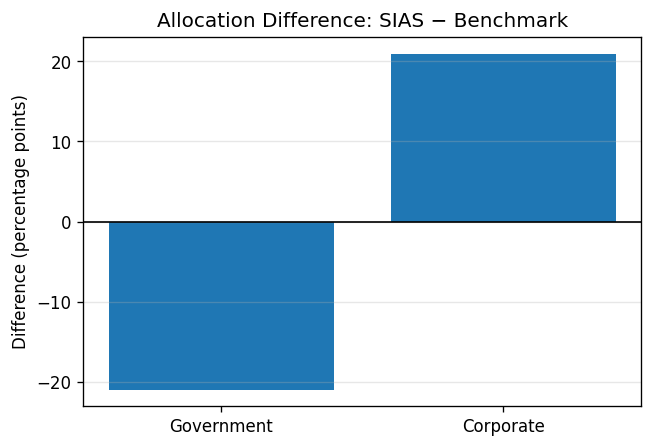

In [ ]:
# ===== BOND TYPE MIX: Gov / Province / Corporate =============================
def _classify_bond(name: str) -> str:
    s = str(name).upper()
    if "GOV" in s or "CANADA" in s:  # Added "CANADA" for government bonds
        return "Gov"
    if "PROV" in s:
        return "Province"
    return "Corporate"

# Portfolio classification
_port_cls = port_df.copy()
_port_cls["BondType"] = _port_cls[PORT_COL["name"]].apply(_classify_bond)

# Benchmark classification
_bm_cls = bm_view.copy()
_bm_cls["BondType"] = _bm_cls["Asset"].apply(_classify_bond)

# Helper to compute percentage weights by type
def _pct_by_type(df, type_col="BondType", wt_col="Weight"):
    g = df.groupby(type_col, dropna=False)[wt_col].sum()
    tot = float(np.nansum(g.values))
    if tot == 0 or not np.isfinite(tot):
        g = g * np.nan
    else:
        g = g / tot
    return g.reindex(["Gov", "Province", "Corporate"]).fillna(0.0)

_port_mix3 = _pct_by_type(_port_cls)
_bm_mix3   = _pct_by_type(_bm_cls)

# Table: Gov / Province / Corporate
mix3_tbl = pd.DataFrame({
    "SIAS (%)": (_port_mix3 * 100).round(2),
    f"{BM_NAME} (%)": (_bm_mix3 * 100).round(2),
}, index=["Gov", "Province", "Corporate"])

print("\nBond Mix — Gov / Province / Corporate")
display(mix3_tbl)

# ===== COMBINE TO GOVERNMENT VS CORPORATE ===================================
port_gov = float(_port_mix3["Gov"] + _port_mix3["Province"])
bm_gov   = float(_bm_mix3["Gov"]   + _bm_mix3["Province"])

port_corp = float(_port_mix3["Corporate"])
bm_corp   = float(_bm_mix3["Corporate"])

govcorp_tbl = pd.DataFrame({
    "SIAS (%)": [round(port_gov*100, 2), round(port_corp*100, 2)],
    f"{BM_NAME} (%)": [round(bm_gov*100, 2), round(bm_corp*100, 2)],
}, index=["Government", "Corporate"])

print("\nAllocation — Government vs Corporate")
display(govcorp_tbl)

# ===== PLOT: Difference (SIAS − Benchmark) ==================================
diff_series = pd.Series({
    "Government": port_gov - bm_gov,
    "Corporate":  port_corp - bm_corp
})
diff_pct = diff_series * 100.0

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(diff_pct.index, diff_pct.values)
ax.axhline(0, linewidth=1, color='black')
ax.set_ylabel("Difference (percentage points)")
ax.set_title("Allocation Difference: SIAS − Benchmark")
ax.grid(True, axis="y", alpha=0.3)
plt.show()


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# STRESS-TEST DASHBOARD  (Parallel • 2s10s Twist • Key-Rate Shocks)
# expects: dur_df  (portfolio DataFrame) and bm_view (benchmark DataFrame/CSV)
# ─────────────────────────────────────────────────────────────────────────────

# ==== 0) Imports & display setup ============================================
import pandas as pd
import numpy as np
import requests
import ipywidgets as w
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

plt.rcParams["figure.dpi"] = 120

# ==== 1) Prep portfolio & benchmark frames ==================================
# Portfolio expected columns (rename here if yours differ):
#   "Base Market Value", "Maturity Date", "ModDur" (or "Duration")

port_df = dur_df.copy()
port_df = port_df.assign(
    MarketValue=pd.to_numeric(port_df["Base Market Value"], errors="coerce"),
    Maturity=pd.to_datetime(port_df["Maturity Date"], errors="coerce"),
    ModDur=pd.to_numeric(port_df.get("ModDur", port_df.get("Duration", np.nan)), errors="coerce"),
)

# Clean numeric columns
for col in ["MarketValue", "ModDur"]:
    port_df[col] = pd.to_numeric(port_df[col], errors="coerce").fillna(0.0)

TOTAL_MV_PORT = float(port_df["MarketValue"].sum())

# Benchmark expects at least ["Market Value" or "MarketValue"], ["Duration" or "ModDur"]
bmk_df = bm_view.copy()
bmk_df = bmk_df.assign(
    MarketValue=pd.to_numeric(
        bmk_df.get("Market Value", bmk_df.get("MarketValue", 0.0)), errors="coerce"
    ).fillna(0.0),
    ModDur=pd.to_numeric(
        bmk_df.get("Duration", bmk_df.get("ModDur", 0.0)), errors="coerce"
    ).fillna(0.0),
    Maturity=pd.to_datetime(bmk_df.get("Maturity", pd.NaT), errors="coerce"),
)
TOTAL_MV_BMK = float(bmk_df["MarketValue"].sum())
TOTAL_MV_ACTIVE = TOTAL_MV_PORT  # use portfolio MV as the base for active % (common convention)

MV_COL, DUR_COL = "MarketValue", "ModDur"
# Settle date: use your portfolio as-of if you have it; otherwise today
SETTLE_DATE = pd.Timestamp.today().normalize()

# ==== 2) Bank of Canada curve fetch (robust) ================================
def get_boc_benchmark_curve():
    """
    Returns DataFrame with columns: Term (years), Yield (percent)
    Uses Bank of Canada Valet API: group=bond_yields_benchmark
    """
    url = "https://www.bankofcanada.ca/valet/observations/group/bond_yields_benchmark/json"
    resp = requests.get(url, timeout=15)
    resp.raise_for_status()
    data = resp.json()

    observations = data.get("observations", [])
    meta = data.get("seriesDetail", {})
    if not observations or not meta:
        raise RuntimeError("BoC Valet response missing observations/seriesDetail")

    latest = observations[-1]
    curve_date = latest.get("d", "unknown")
    print(f"Yield curve as of: {curve_date}")

    rows = []
    for code, detail in meta.items():
        desc = (detail.get("description") or "").lower()
        label = (detail.get("label") or "").lower()
        if "benchmark bond yield" in desc and ("year" in label or "long-term" in label):
            try:
                if "long-term" in label:
                    term_years = 30.0
                else:
                    term_years = float(label.replace(" year", "").strip())
                obs = latest.get(code, {})
                if "v" in obs:
                    yld = float(obs["v"])  # already percent
                    rows.append({"Term": term_years, "Yield": yld})
            except Exception:
                continue

    df_curve = pd.DataFrame(rows).sort_values("Term").reset_index(drop=True)
    if df_curve.empty:
        raise RuntimeError("No benchmark yield points parsed from BoC response")
    return df_curve

try:
    curve_df = get_boc_benchmark_curve()
except Exception as e:
    print("Warning: Failed to fetch BoC curve. Using a dummy flat 3.0% curve. Error:", e)
    curve_df = pd.DataFrame({"Term": [0.5,1,2,3,5,7,10,20,30], "Yield": [3.0]*9})

# ==== 3) Helpers ============================================================
def _tenor_years(series_dates: pd.Series) -> pd.Series:
    """Compute remaining term in years vs SETTLE_DATE, NaT stays NaN."""
    return (series_dates - SETTLE_DATE).dt.days.div(365.25)

def _fmt_pct(x: float, base_mv: float) -> str:
    return f"{(x / base_mv * 100.0):+.3f}%"

def pnl_parallel(df: pd.DataFrame, bp: int) -> float:
    """Parallel shift ΔPV; price ≈ -Dur × Δy × MV (Δy in decimal)."""
    return float((df[DUR_COL] * df[MV_COL] * (-bp / 1e4)).sum())

def pnl_twist(df: pd.DataFrame, bp_short: int, bp_long: int, split_yrs: float = 5.0) -> float:
    """Short bucket < split_yrs gets bp_short; long bucket ≥ split_yrs gets bp_long."""
    if "Maturity" not in df:
        return 0.0
    mat = df["Maturity"]
    mask = mat.notna()
    if not mask.any():
        return 0.0

    ten = _tenor_years(mat[mask])
    is_short = ten.lt(split_yrs)

    fac_s = -bp_short / 1e4
    fac_l = -bp_long  / 1e4

    dur = df.loc[mask, DUR_COL].astype(float)
    mv  = df.loc[mask, MV_COL].astype(float)

    pnl_s = float((dur[is_short] * mv[is_short] * fac_s).sum())
    pnl_l = float((dur[~is_short] * mv[~is_short] * fac_l).sum())
    return pnl_s + pnl_l

# Key-rate buckets (simple maturity buckets; adjust to your house view)
KRD_BUCKETS = [
    (0.0, 3.0,  "2y"),
    (3.0, 7.0,  "5y"),
    (7.0, 15.0, "10y"),
    (15.0, 40.0,"30y"),
]

def pnl_keyrate(df: pd.DataFrame, bucket_bps: dict) -> float:
    """
    Sum ΔPV across maturity buckets. bucket_bps keys must match labels in KRD_BUCKETS.
    Rows with NaT maturity are skipped.
    """
    if "Maturity" not in df:
        return 0.0
    mat = df["Maturity"]
    mask = mat.notna()
    if not mask.any():
        return 0.0

    ten = _tenor_years(mat[mask]).astype(float)
    dur = df.loc[mask, DUR_COL].astype(float)
    mv  = df.loc[mask, MV_COL].astype(float)

    pnl_total = 0.0
    for (lo, hi, label) in KRD_BUCKETS:
        bp = int(bucket_bps.get(label, 0))
        if bp == 0:
            continue
        in_bucket = ten.ge(lo) & ten.lt(hi)
        if not in_bucket.any():
            continue
        fac = -bp / 1e4
        pnl_total += float((dur[in_bucket] * mv[in_bucket] * fac).sum())
    return pnl_total

# ==== 4) PARALLEL SHIFT WIDGET ==============================================
sld_parallel = w.IntSlider(value=25, min=-150, max=150, step=5, description="Shock (bp)")
out_parallel = w.Output()

def _run_parallel(_=None):
    with out_parallel:
        clear_output(wait=True)
        s = sld_parallel.value

        # Curve plot
        fig, ax = plt.subplots(figsize=(6,4))
        ax.plot(curve_df["Term"], curve_df["Yield"], label="Original", lw=2)
        ax.plot(curve_df["Term"], curve_df["Yield"] + s/100,
                label=f"Shifted {s:+} bp", lw=2, ls="--")
        ax.set_xlabel("Term (years)"); ax.set_ylabel("Yield (%)")
        ax.set_title("Gov. of Canada Benchmark Yield Curve")
        ax.grid(True, alpha=0.3); ax.legend()

        p_port = pnl_parallel(port_df, s)
        p_bmk  = pnl_parallel(bmk_df , s)
        p_act  = p_port - p_bmk

        print(f"\nParallel shift  {s:+} bp")
        print(f"  Portfolio ΔPV : {p_port:,.0f}  ({_fmt_pct(p_port, TOTAL_MV_PORT)})")
        print(f"  Benchmark ΔPV : {p_bmk:,.0f}   ({_fmt_pct(p_bmk, TOTAL_MV_BMK)})")
        print(f"  Active   ΔPV  : {p_act:,.0f}   ({_fmt_pct(p_act, TOTAL_MV_ACTIVE)})")

        plt.show()

sld_parallel.observe(_run_parallel, names="value")
_run_parallel()

box_parallel = w.VBox([w.HTML("<b>Parallel-Shift Stress (Yield-Curve View)</b>"),
                       sld_parallel, out_parallel])

# ==== 5) TWIST (2s/10s style) WIDGET =======================================
sld_short = w.IntSlider(value=-10, min=-150, max=150, step=5, description="Short-end bp")
sld_long  = w.IntSlider(value= 10, min=-150, max=150, step=5, description="Long-end bp")
sld_split = w.FloatSlider(value=5.0, min=1.0, max=15.0, step=0.5, readout_format=".1f",
                          description="Split (yrs)")
out_twist = w.Output()

def _run_twist(_=None):
    with out_twist:
        clear_output(wait=True)
        bs, bl, split_yrs = sld_short.value, sld_long.value, sld_split.value

        # curve view
        fig, ax = plt.subplots(figsize=(6,4))
        ax.plot(curve_df["Term"], curve_df["Yield"], label="Original", lw=2)
        y_twisted = curve_df["Yield"] + np.where(curve_df["Term"] < split_yrs, bs/100, bl/100)
        ax.plot(curve_df["Term"], y_twisted, ls="--", lw=2,
                label=f"Twisted (short {bs:+} bp, long {bl:+} bp)")
        ax.set_xlabel("Term (years)"); ax.set_ylabel("Yield (%)")
        ax.set_title("Gov. of Canada Benchmark Yield Curve")
        ax.grid(True, alpha=0.3); ax.legend()

        pnl_p = pnl_twist(port_df, bs, bl, split_yrs)
        pnl_b = pnl_twist(bmk_df , bs, bl, split_yrs)
        pnl_a = pnl_p - pnl_b

        print(f"\nSteepener / Flattener  (short {bs:+} bp, long {bl:+} bp, split {split_yrs:.1f}y)")
        print(f"  Portfolio ΔPV : {pnl_p:,.0f}  ({_fmt_pct(pnl_p, TOTAL_MV_PORT)})")
        print(f"  Benchmark ΔPV : {pnl_b:,.0f}   ({_fmt_pct(pnl_b, TOTAL_MV_BMK)})")
        print(f"  Active  ΔPV   : {pnl_a:,.0f}   ({_fmt_pct(pnl_a, TOTAL_MV_ACTIVE)})")

        plt.show()

for s in (sld_short, sld_long, sld_split):
    s.observe(_run_twist, names="value")
_run_twist()

box_twist = w.VBox([w.HTML("<b>Curve Steepener / Flattener Stress</b>"),
                    w.HBox([sld_short, sld_long, sld_split]),
                    out_twist])

# ==== 6) KEY-RATE SHOCKS (bucketed) WIDGET =================================
bucket_sliders = {label: w.IntSlider(value=0, min=-150, max=150, step=5, description=f"{label} (bp)")
                  for (_, _, label) in KRD_BUCKETS}
out_krd = w.Output()

def _current_bucket_bps():
    return {label: s.value for label, s in bucket_sliders.items()}

def _run_krd(_=None):
    with out_krd:
        clear_output(wait=True)
        bps = _current_bucket_bps()

        # curve view with bucket bumps (piecewise visualization)
        fig, ax = plt.subplots(figsize=(6,4))
        ax.plot(curve_df["Term"], curve_df["Yield"], label="Original", lw=2)

        y_bumped = curve_df["Yield"].copy()
        for (lo, hi, label) in KRD_BUCKETS:
            bp = bps.get(label, 0)
            if bp == 0:
                continue
            sel = (curve_df["Term"] >= lo) & (curve_df["Term"] < hi)
            y_bumped.loc[sel] = y_bumped.loc[sel] + bp / 100.0

        ax.plot(curve_df["Term"], y_bumped, ls="--", lw=2, label="Key-rate bumped")
        ax.set_xlabel("Term (years)"); ax.set_ylabel("Yield (%)")
        ax.set_title("Gov. of Canada Benchmark Yield Curve")
        ax.grid(True, alpha=0.3); ax.legend()

        p_port = pnl_keyrate(port_df, bps)
        p_bmk  = pnl_keyrate(bmk_df , bps)
        p_act  = p_port - p_bmk

        print("Key-Rate Shocks (bucketed, ΔPV via ModDur in bucket)")
        for label in bps:
            print(f"  {label:<4}: {bps[label]:+} bp")
        print(f"\n  Portfolio ΔPV : {p_port:,.0f}  ({_fmt_pct(p_port, TOTAL_MV_PORT)})")
        print(f"  Benchmark ΔPV : {p_bmk:,.0f}   ({_fmt_pct(p_bmk, TOTAL_MV_BMK)})")
        print(f"  Active   ΔPV  : {p_act:,.0f}   ({_fmt_pct(p_act, TOTAL_MV_ACTIVE)})")

        plt.show()

for s in bucket_sliders.values():
    s.observe(_run_krd, names="value")
_run_krd()

box_krd = w.VBox([
    w.HTML("<b>Key-Rate (Bucket) Shocks</b>"),
    w.HBox(list(bucket_sliders.values())),
    out_krd
])

# ==== 7) DISPLAY DASHBOARD ==================================================
display(w.VBox([
    w.HTML("<h3>Stress-Test Dashboard</h3>"),
    box_parallel,
    w.HTML("<hr>"),
    box_twist,
    w.HTML("<hr>"),
    box_krd
]))


Yield curve as of: 2025-08-07
